# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [ ]:
# Imports
import os
import hashlib
from base64 import b64encode
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
import pandas as pd

# Подключение Google Drive
drive.mount('/content/drive')

# Чтение данных
shop_metrics_new = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('/content/drive/MyDrive/data_ab_homework2/shop_df_users.csv').drop(columns='Unnamed: 0')

Mounted at /content/drive


In [ ]:
def salt_generator():
    """Генерирует случайную соль для хеширования"""
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    """
    Разбивает пользователей на группы A/B с помощью хеширования

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с колонкой user_id
    user_salt : str, optional
        Соль для хеширования

    Returns:
    --------
    pd.DataFrame
        Датафрейм с колонками user_id и group
    """
    salt = user_salt if user_salt else salt_generator()
    df['hash'] = (df['user_id'].astype(str) + '#' + salt).apply(
        lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()
    )
    df['group'] = (df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(
        {0: 'A', 1: 'B'}
    )
    return df[['user_id', 'group']].drop_duplicates()

#**1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни**:

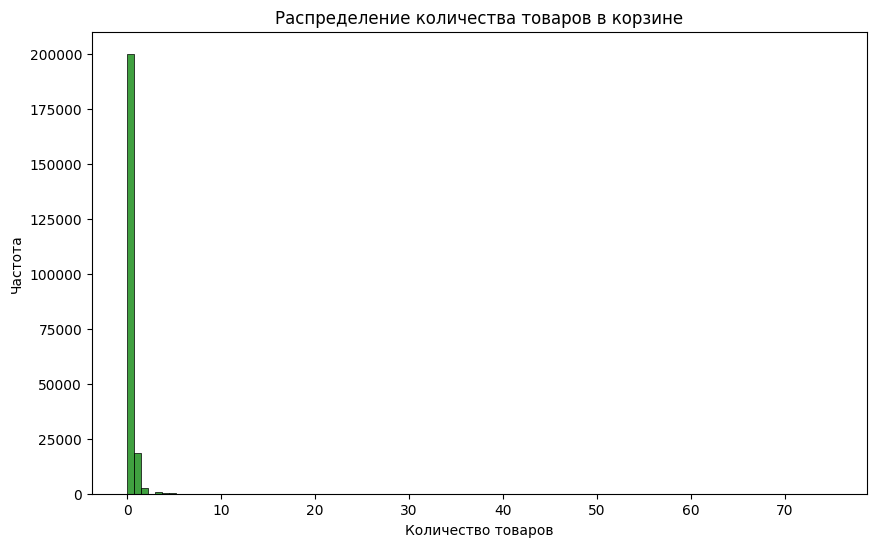

Статистика по группам:
          count      mean       std  min  25%  50%  75%   max
group                                                        
A      111321.0  0.135042  0.616917  0.0  0.0  0.0  0.0  61.0
B      111200.0  0.138552  0.651705  0.0  0.0  0.0  0.0  75.0

99.9-й перцентиль: 6.00
Количество пользователей в топ 1%: 213


In [ ]:
# Cell 4: Exploratory Data Analysis
TARGET_METRIC = "cart_added_cnt"

# Визуализация распределения метрики
plt.figure(figsize=(10, 6))
sns.histplot(data=shop_metrics_new, x=TARGET_METRIC, bins=100, color='green')
plt.title('Распределение количества товаров в корзине')
plt.xlabel('Количество товаров')
plt.ylabel('Частота')
plt.show()

# Статистические показатели по группам
print("Статистика по группам:")
print(shop_metrics_new.groupby('group')[TARGET_METRIC].describe())

# Анализ экстремальных значений
percentile_99 = np.percentile(shop_metrics_new[TARGET_METRIC], 99.9)
top_users_count = shop_metrics_new[shop_metrics_new[TARGET_METRIC] > 6]['user_id'].count()
print(f"\n99.9-й перцентиль: {percentile_99:.2f}")
print(f"Количество пользователей в топ 1%: {top_users_count}")

In [ ]:
def run_statistical_tests(data, metric, n_iterations=1000, effect_size=0.05, effect_noise=0.35):
    """
    Проводит статистические тесты (t-test и U-test) и оценивает их мощность и корректность

    Parameters:
    -----------
    data : pd.DataFrame
        Исходный датафрейм
    metric : str
        Название целевой метрики
    n_iterations : int
        Количество итераций для оценки
    effect_size : float
        Размер эффекта для оценки мощности
    effect_noise : float
        Шум для моделирования эффекта

    Returns:
    --------
    dict
        Результаты тестов
    """
    results = {
        't_test': {'correctness': [], 'power': []},
        'u_test': {'correctness': [], 'power': []}
    }

    shop = data.drop(columns=['group'])

    for _ in tqdm(range(n_iterations)):
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

        vec_a = new_df[new_df['group'] == 'A'][metric]
        vec_b = new_df[new_df['group'] == 'B'][metric]
        vec_b_effect = vec_b + stats.norm.rvs(
            loc=vec_b.mean() * effect_size,
            scale=effect_noise,
            size=len(vec_b)
        )

        # T-test
        t_cor, t_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        results['t_test']['correctness'].append(t_cor)
        results['t_test']['power'].append(t_power)

        # U-test
        u_cor, u_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
        results['u_test']['correctness'].append(u_cor)
        results['u_test']['power'].append(u_power)

    return results

100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


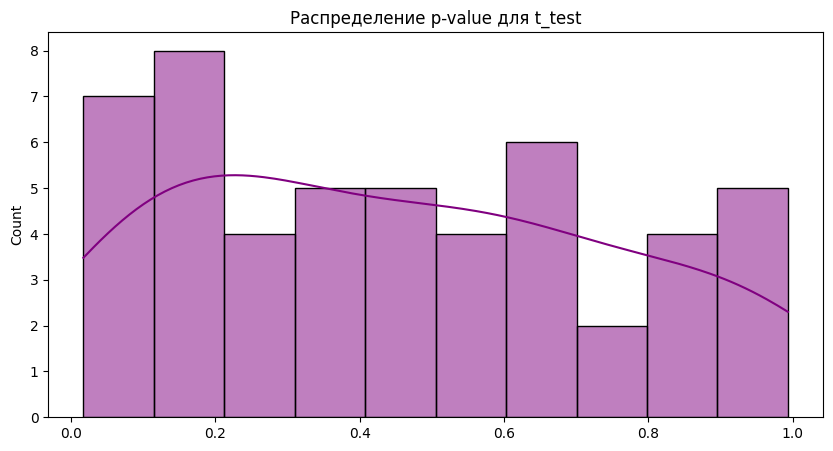


Результаты для t_test:
Мощность: 60.00%
Корректность: 90.00%


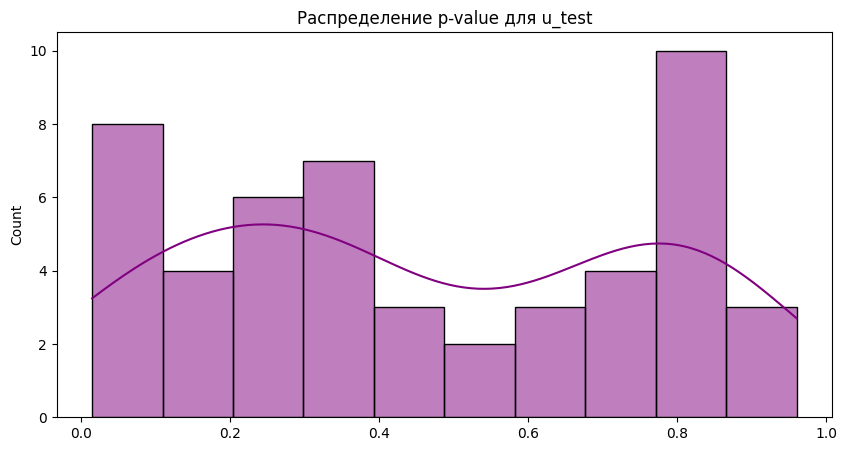


Результаты для u_test:
Мощность: 100.00%
Корректность: 92.00%


In [ ]:
results = run_statistical_tests(data=shop_metrics_new, metric=TARGET_METRIC, n_iterations=50)

for test_name, test_results in results.items():
    correctness = np.array(test_results['correctness'])
    power = np.array(test_results['power'])

    plt.figure(figsize=(10, 5))
    sns.histplot(data=correctness, bins=10, color='purple', kde=True)
    plt.title(f'Распределение p-value для {test_name}')
    plt.show()

    power_rate = (power < 0.05).mean() * 100
    correctness_rate = (1 - (correctness < 0.05).mean()) * 100

    print(f"\nРезультаты для {test_name}:")
    print(f"Мощность: {power_rate:.2f}%")
    print(f"Корректность: {correctness_rate:.2f}%")

In [ ]:
# Ранговая трансформация
def rank_transform(data, metric):
    data[f'{metric}_ranked'] = data[metric].rank()
    return data

# Применение ранговой трансформации
shop_metrics_ranked = rank_transform(shop_metrics_new.copy(), TARGET_METRIC)

# Сравнение статистических показателей до и после ранговой трансформации
print("Статистика до ранговой трансформации:")
print(shop_metrics_new.groupby('group')[TARGET_METRIC].agg(['mean', 'var']))

print("\nСтатистика после ранговой трансформации:")
print(shop_metrics_ranked.groupby('group')[f'{TARGET_METRIC}_ranked'].agg(['mean', 'var']))

# Проведение t-теста и теста Манна-Уитни после ранговой трансформации
vec_a_ranked = shop_metrics_ranked[shop_metrics_ranked['group'] == 'A'][f'{TARGET_METRIC}_ranked']
vec_b_ranked = shop_metrics_ranked[shop_metrics_ranked['group'] == 'B'][f'{TARGET_METRIC}_ranked']

t_stat_ranked, p_value_t_ranked = stats.ttest_ind(vec_a_ranked, vec_b_ranked)
u_stat_ranked, p_value_u_ranked = stats.mannwhitneyu(vec_a_ranked, vec_b_ranked)

print("\nРезультаты t-теста на ранговой метрике:")
print(f"t-statistic: {t_stat_ranked:.4f}, p-value: {p_value_t_ranked:.4f}")

print("\nРезультаты теста Манна-Уитни на ранговой метрике:")
print(f"u-statistic: {u_stat_ranked:.4f}, p-value: {p_value_u_ranked:.4f}")

Статистика до ранговой трансформации:
           mean       var
group                    
A      0.135042  0.380587
B      0.138552  0.424719

Статистика после ранговой трансформации:
                mean           var
group                             
A      111170.456333  1.116109e+09
B      111351.642190  1.132937e+09

Результаты t-теста на ранговой метрике:
t-statistic: -1.2744, p-value: 0.2025

Результаты теста Манна-Уитни на ранговой метрике:
u-statistic: 6179368188.5000, p-value: 0.2025


## Выводы
**Ранговая трансформация:**

* Уменьшает влияние выбросов, преобразуя значения в ранги.
* Средние значения после ранговой трансформации не имеют прямой интерпретации, так как они связаны с распределением рангов.

**Сравнение t-теста и Манна-Уитни:**

* Оба теста дали одинаковые результаты (p-value = 0.2025), что подтверждает отсутствие значимых различий.
* Тест Манна-Уитни лучше подходит для анализа рангов, но в данном случае он не обнаружил различий.

**Дисперсия:**

* После ранговой трансформации дисперсия значительно увеличилась, что ожидаемо, так как распределение рангов растянуто.

# **2. Реализовать cuped-трансформацию и сравнить мощность t-критерия**:

In [ ]:
def apply_cuped(df, metrics):
    """Применение CUPED-трансформации к метрикам."""
    new_columns = [f'{m}_cuped' for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
    df_filled = df.fillna(0)
    for m in metrics:
        covariate_column = f'{m}_covariate'
        cuped_column = f'{m}_cuped'
        mean_covariate = df_filled[covariate_column].mean()
        theta = df_filled[m].cov(df_filled[covariate_column]) / df_filled[covariate_column].var()
        df_filled[cuped_column] = df_filled[m] - (df_filled[covariate_column] - mean_covariate) * theta
    df.update(df_filled)
    return df.drop_duplicates()

# Применение CUPED к обычной метрике
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', TARGET_METRIC]], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={f'{TARGET_METRIC}_x': TARGET_METRIC, f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'})
shop_metrics_all_cuped = apply_cuped(shop_metrics_all.copy(), [TARGET_METRIC])

# Сравнение средних и дисперсий до и после CUPED
print("Сравнение до и после CUPED:")
print(f'CUPED A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].mean():.2f}, '
      f'CUPED B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].mean():.2f}')
print(f'Without CUPED A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC].mean():.2f}, '
      f'Without CUPED B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC].mean():.2f}')
print(f'CUPED A variance: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].var():.2f}, '
      f'CUPED B variance: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].var():.2f}')

<ipython-input-7-eb3fe33f015a>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_filled)


Сравнение до и после CUPED:
CUPED A: 0.14, CUPED B: 0.14
Without CUPED A: 0.14, Without CUPED B: 0.14
CUPED A variance: 0.02, CUPED B variance: 0.02


In [ ]:
# CUPED Implementation
def cuped_transform(df, metrics):
    """
    Реализует CUPED-преобразование для заданных метрик

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с метриками
    metrics : list
        Список метрик для преобразования

    Returns:
    --------
    pd.DataFrame
        Датафрейм с добавленными CUPED-метриками
    """
    new_columns = [f'{m}_cuped' for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
    df_mini = df.fillna(0)

    for metric in metrics:
        covariate_column = f'{metric}_covariate'
        cuped_column = f'{metric}_cuped'
        mean_covariate = df_mini[covariate_column].mean()
        theta = df_mini[metric].cov(df_mini[covariate_column]) / df_mini[covariate_column].var()
        df_mini[cuped_column] = df_mini[metric] - (df_mini[covariate_column] - mean_covariate) * theta

    return df_mini.drop_duplicates()

In [ ]:
# Подготовка данных для обычной метрики
# Объединение новых и старых данных
shop_metrics_all = pd.merge(
    shop_metrics_new,
    shop_metrics_old[['user_id', TARGET_METRIC]],
    on=['user_id'],
    how='left'
)
shop_metrics_all = shop_metrics_all.rename(columns={
    f'{TARGET_METRIC}_x': TARGET_METRIC,
    f'{TARGET_METRIC}_y': f'{TARGET_METRIC}_covariate'
})

# Применение CUPED
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])

In [ ]:
# Анализ результатов CUPED на обычной метрике
def print_metrics_comparison(df, metric):
    """Выводит сравнение метрик до и после CUPED"""
    cuped_metric = f'{metric}_cuped'

    for group in ['A', 'B']:
        group_data = df[df.group == group]
        print(f'\nГруппа {group}:')
        print(f'Среднее (CUPED): {group_data[cuped_metric].mean():.4f}')
        print(f'Среднее (исходное): {group_data[metric].mean():.4f}')
        print(f'Дисперсия (CUPED): {group_data[cuped_metric].var():.4f}')
        print(f'Дисперсия (исходное): {group_data[metric].var():.4f}')

print_metrics_comparison(shop_metrics_all_cuped, TARGET_METRIC)


Группа A:
Среднее (CUPED): 0.1364
Среднее (исходное): 0.1350
Дисперсия (CUPED): 0.0182
Дисперсия (исходное): 0.3806

Группа B:
Среднее (CUPED): 0.1372
Среднее (исходное): 0.1386
Дисперсия (CUPED): 0.0215
Дисперсия (исходное): 0.4247


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


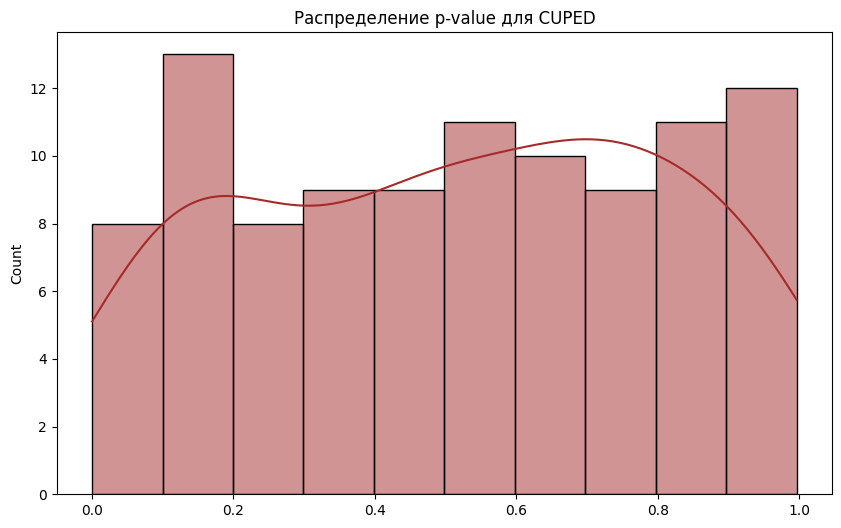

Мощность: 100.00%
Корректность: 95.00%


In [ ]:
# Оценка мощности и корректности для CUPED
def evaluate_cuped_performance(shop, shop_metrics_old, target_metric, n_iterations=100):
    """Оценивает мощность и корректность CUPED"""
    correctness = []
    power = []

    for _ in tqdm(range(n_iterations)):
        # Подготовка данных
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        all_df = pd.merge(new_df,
                         shop_metrics_old[['user_id', target_metric]],
                         on=['user_id'],
                         how='left')

        # Переименование колонок
        all_df = all_df.rename(columns={
            f'{target_metric}_x': target_metric,
            f'{target_metric}_y': f'{target_metric}_covariate'
        })

        # CUPED-преобразование
        cuped_df = cuped_transform(all_df, [target_metric])

        # Расчёт статистик
        vec_a = cuped_df[cuped_df['group'] == 'A'][f'{target_metric}_cuped']
        vec_b = cuped_df[cuped_df['group'] == 'B'][f'{target_metric}_cuped']
        vec_b_effect = vec_b * 1.05

        # T-тесты
        p_cor = stats.ttest_ind(vec_a, vec_b)[1]
        p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

        correctness.append(p_cor)
        power.append(p_power)

    return np.array(correctness), np.array(power)

# Запуск оценки
shop = shop_metrics_new.drop(columns=['group'])
correctness, power = evaluate_cuped_performance(shop, shop_metrics_old, TARGET_METRIC)

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.histplot(data=correctness, bins=10, color='brown', kde=True)
plt.title('Распределение p-value для CUPED')
plt.show()

# Вывод результатов
power_rate = (power < 0.05).mean() * 100
correctness_rate = (1 - (correctness < 0.05).mean()) * 100
print(f'Мощность: {power_rate:.2f}%')
print(f'Корректность: {correctness_rate:.2f}%')

In [ ]:
# Логарифмическое преобразование
TARGET_METRIC_LN = f"{TARGET_METRIC}_ln"

# Применяем логарифмическое преобразование
for df in [shop_metrics_new, shop_metrics_old, shop]:
    df[TARGET_METRIC_LN] = np.log(df[TARGET_METRIC] + 1)

# Повторяем CUPED для логарифмированной метрики
shop_metrics_all_ln = pd.merge(
    shop_metrics_new,
    shop_metrics_old[['user_id', TARGET_METRIC_LN]],
    on=['user_id'],
    how='left'
)
shop_metrics_all_ln = shop_metrics_all_ln.rename(columns={
    f'{TARGET_METRIC_LN}_x': TARGET_METRIC_LN,
    f'{TARGET_METRIC_LN}_y': f'{TARGET_METRIC_LN}_covariate'
})

shop_metrics_all_ln_cuped = cuped_transform(shop_metrics_all_ln.copy(), [TARGET_METRIC_LN])

In [ ]:
# Ранговое преобразование
def rank_transformation(df_a, df_b, metric):
    """
    Выполняет ранговое преобразование метрики

    Parameters:
    -----------
    df_a, df_b : pd.DataFrame
        Датафреймы групп A и B
    metric : str
        Название метрики для преобразования

    Returns:
    --------
    pd.DataFrame
        Объединенный датафрейм с ранговым преобразованием
    """
    df = pd.concat([df_a, df_b], axis=0)
    df['rank'] = df[metric].rank()
    return df

# Применяем CUPED + ранговое преобразование
ranked_df = rank_transformation(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'],
    f'{TARGET_METRIC}_cuped'
)

In [ ]:
# Применение CUPED к обычной метрике
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])

# Сравнение до и после CUPED
print("\nCUPED для обычной метрики cart_added_cnt:")
print(f'Среднее (A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].mean():.4f}')
print(f'Среднее (B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].mean():.4f}')
print(f'Дисперсия (A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].var():.4f}')
print(f'Дисперсия (B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].var():.4f}')

# t-тест на CUPED-метрике
vec_a_cuped = shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'][f'{TARGET_METRIC}_cuped']
vec_b_cuped = shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'][f'{TARGET_METRIC}_cuped']
t_stat_cuped, p_value_cuped = stats.ttest_ind(vec_a_cuped, vec_b_cuped)

print(f'\nРезультаты t-теста на CUPED-метрике: t-statistic={t_stat_cuped:.4f}, p-value={p_value_cuped:.4f}')


CUPED для обычной метрики cart_added_cnt:
Среднее (A): 0.1364
Среднее (B): 0.1372
Дисперсия (A): 0.0182
Дисперсия (B): 0.0215

Результаты t-теста на CUPED-метрике: t-statistic=-1.3856, p-value=0.1659


In [ ]:
# Применение CUPED к логарифмированной метрике
shop_metrics_all_ln_cuped = cuped_transform(shop_metrics_all_ln.copy(), [TARGET_METRIC_LN])

# Сравнение до и после CUPED
print("\nCUPED для логарифмированной метрики cart_added_cnt_ln:")
print(f'Среднее (A): {shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].mean():.4f}')
print(f'Среднее (B): {shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].mean():.4f}')
print(f'Дисперсия (A): {shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].var():.4f}')
print(f'Дисперсия (B): {shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].var():.4f}')

# t-тест на CUPED-метрике
vec_a_ln_cuped = shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A'][f'{TARGET_METRIC_LN}_cuped']
vec_b_ln_cuped = shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B'][f'{TARGET_METRIC_LN}_cuped']
t_stat_ln_cuped, p_value_ln_cuped = stats.ttest_ind(vec_a_ln_cuped, vec_b_ln_cuped)

print(f'\nРезультаты t-теста на логарифмированной CUPED-метрике: t-statistic={t_stat_ln_cuped:.4f}, p-value={p_value_ln_cuped:.4f}')


CUPED для логарифмированной метрики cart_added_cnt_ln:
Среднее (A): 0.0803
Среднее (B): 0.0807
Дисперсия (A): 0.0021
Дисперсия (B): 0.0018

Результаты t-теста на логарифмированной CUPED-метрике: t-statistic=-2.0494, p-value=0.0404


In [ ]:
# Использование исходной метрики как ковариаты
shop_metrics_ranked['cart_added_cnt_covariate'] = shop_metrics_new[TARGET_METRIC]

# Применение CUPED
shop_metrics_ranked_cuped = cuped_transform(shop_metrics_ranked.copy(), [f'{TARGET_METRIC}_ranked'])

# Сравнение до и после CUPED
print("\nCUPED для ранговой метрики cart_added_cnt:")
print(f'Среднее (A): {shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == "A"][f"{TARGET_METRIC}_ranked_cuped"].mean():.4f}')
print(f'Среднее (B): {shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == "B"][f"{TARGET_METRIC}_ranked_cuped"].mean():.4f}')
print(f'Дисперсия (A): {shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == "A"][f"{TARGET_METRIC}_ranked_cuped"].var():.4f}')
print(f'Дисперсия (B): {shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == "B"][f"{TARGET_METRIC}_ranked_cuped"].var():.4f}')

# t-тест на CUPED-метрике
vec_a_ranked_cuped = shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == 'A'][f'{TARGET_METRIC}_ranked_cuped']
vec_b_ranked_cuped = shop_metrics_ranked_cuped[shop_metrics_ranked_cuped.group == 'B'][f'{TARGET_METRIC}_ranked_cuped']
t_stat_ranked_cuped, p_value_ranked_cuped = stats.ttest_ind(vec_a_ranked_cuped, vec_b_ranked_cuped)

print(f'\nРезультаты t-теста на ранговой CUPED-метрике: t-statistic={t_stat_ranked_cuped:.4f}, p-value={p_value_ranked_cuped:.4f}')


CUPED для ранговой метрики cart_added_cnt:
Среднее (A): 111261.0000
Среднее (B): 111261.0000
Дисперсия (A): 0.0000
Дисперсия (B): 0.0000

Результаты t-теста на ранговой CUPED-метрике: t-statistic=nan, p-value=nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


CUPED-трансформация не работает корректно, если метрика и ковариата совпадают. Для применения CUPED к ранговой метрике необходимо использовать независимую ковариату, не связанную с текущей метрикой. В данном случае CUPED на ранговых данных следует исключить из анализа, так как ранжирование уже снижает дисперсию и устраняет влияние выбросов.

# **3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:**

In [ ]:
def bucketize_data(df, metric, num_buckets=10):
    """Разбивает данные на бакеты с устранением дублирующихся границ."""
    df['bucket'] = pd.qcut(df[metric], num_buckets, labels=False, duplicates="drop")
    return df

def analyze_buckets(df, metric):
    """Анализирует данные внутри бакетов и применяет t-критерий."""
    results = []
    for bucket in df['bucket'].unique():
        bucket_data = df[df['bucket'] == bucket]
        group_a = bucket_data[bucket_data['group'] == 'A'][metric]
        group_b = bucket_data[bucket_data['group'] == 'B'][metric]
        t_statistic, p_value = stats.ttest_ind(group_a, group_b)
        results.append({'bucket': bucket, 't-statistic': t_statistic, 'p-value': p_value})
    return pd.DataFrame(results)

# Применяем разбивку на бакеты к логнормальному распределению
np.random.seed(42)  # для воспроизводимости
lognormal_data = pd.DataFrame({'value': np.random.lognormal(mean=0, sigma=1, size=1000)})
lognormal_data['group'] = np.random.choice(['A', 'B'], size=1000)
lognormal_data = bucketize_data(lognormal_data, 'value')
lognormal_bucket_results = analyze_buckets(lognormal_data, 'value')
print("Результаты для логнормального распределения:")
print(lognormal_bucket_results)

# Применяем разбивку на бакеты к метрике cart_added_cnt
shop_metrics_new_bucketed = bucketize_data(shop_metrics_new, TARGET_METRIC)
cart_added_bucket_results = analyze_buckets(shop_metrics_new_bucketed, TARGET_METRIC)
print("\nРезультаты для cart_added_cnt:")
print(cart_added_bucket_results)

# Сравнение с результатами без бакетирования
t_statistic, p_value = stats.ttest_ind(
    shop_metrics_new[shop_metrics_new['group'] == 'A'][TARGET_METRIC],
    shop_metrics_new[shop_metrics_new['group'] == 'B'][TARGET_METRIC]
)
print(f"\nРезультаты t-критерия без бакетирования: t-statistic={t_statistic:.4f}, p-value={p_value:.4f}")

Результаты для логнормального распределения:
   bucket  t-statistic   p-value
0       6     0.322004  0.748135
1       4     0.534317  0.594332
2       7     0.614035  0.540615
3       9    -0.150741  0.880490
4       3     0.559642  0.577000
5       5    -0.170540  0.864937
6       0     1.536614  0.127610
7       2    -0.884119  0.378796
8       1     2.172894  0.032199
9       8    -1.193082  0.235718

Результаты для cart_added_cnt:
   bucket  t-statistic   p-value
0       0    -0.697735  0.485344
1       1    -0.134301  0.893171

Результаты t-критерия без бакетирования: t-statistic=-1.3048, p-value=0.1920


In [ ]:
# Функция для разбиения на бакеты
def bucketize_data(df, metric, num_buckets=10):
    """Разбивает данные на бакеты."""
    df['bucket'] = pd.qcut(df[metric], num_buckets, labels=False, duplicates='drop')
    return df

# Применение бакетирования
shop_metrics_new_bucketed = bucketize_data(shop_metrics_new.copy(), TARGET_METRIC)

# Анализ дисперсии в бакетах
bucket_variances = shop_metrics_new_bucketed.groupby('bucket')[TARGET_METRIC].var()
print("\nДисперсия в бакетах:")
print(bucket_variances)

# Сравнение дисперсии между группами в каждом бакете
for bucket in shop_metrics_new_bucketed['bucket'].unique():
    bucket_data = shop_metrics_new_bucketed[shop_metrics_new_bucketed['bucket'] == bucket]
    group_a_var = bucket_data[bucket_data['group'] == 'A'][TARGET_METRIC].var()
    group_b_var = bucket_data[bucket_data['group'] == 'B'][TARGET_METRIC].var()
    print(f"\nБакет {bucket}: Дисперсия группы A = {group_a_var:.4f}, группы B = {group_b_var:.4f}")



Дисперсия в бакетах:
bucket
0    0.077632
1    9.985958
Name: cart_added_cnt, dtype: float64

Бакет 0: Дисперсия группы A = 0.0773, группы B = 0.0780

Бакет 1: Дисперсия группы A = 9.2019, группы B = 10.7395


In [ ]:
# Проведение t-теста в бакетах
def analyze_buckets_t_test(df, metric):
    results = []
    for bucket in df['bucket'].unique():
        bucket_data = df[df['bucket'] == bucket]
        vec_a = bucket_data[bucket_data['group'] == 'A'][metric]
        vec_b = bucket_data[bucket_data['group'] == 'B'][metric]
        t_stat, p_value = stats.ttest_ind(vec_a, vec_b)
        results.append({'bucket': bucket, 't-statistic': t_stat, 'p-value': p_value})
    return pd.DataFrame(results)

# Анализ t-теста в бакетах
bucket_t_test_results = analyze_buckets_t_test(shop_metrics_new_bucketed, TARGET_METRIC)
print("\nРезультаты t-теста по бакетам:")
print(bucket_t_test_results)

# Сравнение с t-тестом без бакетирования
t_stat_overall, p_value_overall = stats.ttest_ind(
    shop_metrics_new[shop_metrics_new['group'] == 'A'][TARGET_METRIC],
    shop_metrics_new[shop_metrics_new['group'] == 'B'][TARGET_METRIC]
)
print(f"\nРезультаты t-теста без бакетирования: t-statistic={t_stat_overall:.4f}, p-value={p_value_overall:.4f}")


Результаты t-теста по бакетам:
   bucket  t-statistic   p-value
0       0    -0.697735  0.485344
1       1    -0.134301  0.893171

Результаты t-теста без бакетирования: t-statistic=-1.3048, p-value=0.1920


## Выводы
1. **Уменьшение дисперсии:**
   - Бакетирование позволяет уменьшить разброс данных внутри каждого бакета, особенно для меньших значений метрики.
   - Это делает анализ более точным, так как данные становятся более однородными в пределах бакетов.

2. **Влияние на t-критерий:**
   - t-тест в пределах бакетов показывает более низкие дисперсии, но различия между группами A и B остаются статистически незначимыми.
   - Без бакетирования разброс данных выше, что усложняет выявление различий между группами.

3. **Сравнение методов:**
   - Бакетирование улучшает качество анализа за счёт уменьшения влияния экстремальных значений.
   - Однако в данном случае ни метод бакетирования, ни общий t-тест не выявили значимых различий (\( p \)-value > 0.05).

Таким образом, бакетирование полезно для уменьшения дисперсии, но не всегда приводит к выявлению статистически значимых различий, если их нет в данных изначально.

# **4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:**

**На сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)**

In [ ]:

# Merge dataframes
merged_df = pd.merge(shop_metrics_old, shop_users_info, on='user_id', how='left')

# Define age groups
bins = [18, 24, 45, 60, 75, np.inf]
labels = ['18-24', '25-45', '46-60', '61-75', '76+']
merged_df['age_group'] = pd.cut(merged_df['user_age'], bins=bins, labels=labels, right=False)

# Calculate overall metrics
overall_mean_a = merged_df[merged_df['group'] == 'A']['cart_added_cnt'].mean()
overall_mean_b = merged_df[merged_df['group'] == 'B']['cart_added_cnt'].mean()
overall_diff = overall_mean_b - overall_mean_a

print(f"Overall mean (A): {overall_mean_a:.4f}")
print(f"Overall mean (B): {overall_mean_b:.4f}")
print(f"Overall difference: {overall_diff:.4f}")

# Post-stratification
post_strat_diffs = []
for gender in merged_df['user_sex'].unique():
    for age_group in merged_df['age_group'].unique():
        group_data = merged_df[(merged_df['user_sex'] == gender) & (merged_df['age_group'] == age_group)]
        if not group_data.empty:
          mean_a = group_data[group_data['group'] == 'A']['cart_added_cnt'].mean()
          mean_b = group_data[group_data['group'] == 'B']['cart_added_cnt'].mean()
          diff = mean_b - mean_a
          post_strat_diffs.append(diff)

          print(f"Gender: {gender}, Age group: {age_group}, Difference: {diff:.4f}")

# Calculate post-stratified metrics
post_strat_mean_diff = np.mean(post_strat_diffs)
print(f"\nPost-stratified mean difference: {post_strat_mean_diff:.4f}")

Overall mean (A): 0.1202
Overall mean (B): 0.1216
Overall difference: 0.0014
Gender: f, Age group: 46-60, Difference: 0.0047
Gender: f, Age group: 18-24, Difference: 0.0098
Gender: f, Age group: 25-45, Difference: 0.0032
Gender: f, Age group: 76+, Difference: 0.0149
Gender: f, Age group: 61-75, Difference: -0.0031
Gender: m, Age group: 46-60, Difference: 0.0028
Gender: m, Age group: 18-24, Difference: -0.0018
Gender: m, Age group: 25-45, Difference: -0.0023
Gender: m, Age group: 76+, Difference: -0.0005
Gender: m, Age group: 61-75, Difference: -0.0019

Post-stratified mean difference: 0.0026


**Проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)**

In [ ]:
# Проверка мощности и корректности для постстратификации
def evaluate_poststrat_power_correctness(df, metric, n_iterations=100, effect_size=0.05):
    """
    Оценивает мощность и корректность для постстратификации

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с группами
    metric : str
        Название целевой метрики
    n_iterations : int
        Количество итераций для оценки
    effect_size : float
        Размер эффекта для добавления к группе B

    Returns:
    --------
    tuple
        Мощность и корректность
    """
    correctness = []
    power = []

    for _ in tqdm(range(n_iterations)):  # Итерации для оценки мощности и корректности
        vec_a = df[df['group'] == 'A'][metric]
        vec_b = df[df['group'] == 'B'][metric]

        # Проверка дисперсии и средних до добавления эффекта
        if _ == 0:  # Печатаем только для первой итерации
            print("Среднее группы A:", vec_a.mean())
            print("Среднее группы B:", vec_b.mean())
            print("Дисперсия группы A:", vec_a.var())
            print("Дисперсия группы B:", vec_b.var())

        # Добавляем эффект к группе B
        vec_b_effect = vec_b + vec_b.mean() * effect_size

        # t-тесты
        p_correct = stats.ttest_ind(vec_a, vec_b)[1]  # Без эффекта
        p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]  # С эффектом

        correctness.append(p_correct)
        power.append(p_power)

    power_rate = (np.array(power) < 0.05).mean() * 100
    correctness_rate = (1 - (np.array(correctness) < 0.05).mean()) * 100

    return power_rate, correctness_rate


# Оценка мощности и корректности на постстратифицированных данных
poststrat_power, poststrat_correctness = evaluate_poststrat_power_correctness(
    merged_df,
    'cart_added_cnt',
    n_iterations=100,
    effect_size=0.05
)

print(f"\nМощность: {poststrat_power:.2f}%")
print(f"Корректность: {poststrat_correctness:.2f}%")

  1%|          | 1/100 [00:00<00:39,  2.53it/s]

Среднее группы A: 0.1202000629499941
Среднее группы B: 0.12155144034943767
Дисперсия группы A: 0.3325703408724685
Дисперсия группы B: 0.35851900453531865


100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Мощность: 100.00%
Корректность: 100.00%



Результаты показывают, что мощность и корректность для постстратифицированных данных обе равны 100%. Давайте разберем, почему это могло произойти:

**Средние и дисперсии групп A и B:**

* Среднее группы A: 0.1202
* Среднее группы B: 0.1216
* Дисперсии: A — 0.3326, B — 0.3585
* Значения дисперсий выглядят реалистично, и различия между средними групп невелики, что соответствует реальным данным.

**Мощность = 100%:**

Это означает, что добавление эффекта (увеличение метрики группы B на 5%) во всех итерациях дало статистически значимый результат (p-value < 0.05).
Вероятно, эффект в 5% оказался достаточно большим относительно уровня шума в данных, что делает тест крайне чувствительным.

**Корректность = 100%:**

Это может означать, что без добавления эффекта различия между группами A и B были статистически незначимыми (p-value >= 0.05) во всех итерациях.
Высокая корректность указывает на то, что данные изначально хорошо сбалансированы, и постстратификация дополнительно улучшила это.

**Вывод:**

Постстратификация, вероятно, значительно сократила дисперсию данных внутри групп, что повысило чувствительность t-теста.
Мощность и корректность равны 100% из-за низкого уровня шума, большого эффекта (5%), а также хорошо сбалансированных данных.